# Embeddings Introduction
## NLP Tasks using Embeddings
[MTEB - Massive Text Embedding Benchmark](https://huggingface.co/spaces/mteb/leaderboard)

- MTEB consists of 58 datasets covering 112 languages <br>
- 8 embedding tasks:
  1. Bitext mining - Used to match two different language sentences. F1 metric, accuracy, precision, recall
  2. Classification - Transform text into feature vectors and use them to train a logistic regression classifier. Accuracy, average precision, F1
  3. Clustering - Like k-means, group sentences into clusters. v-measure
  4. Pair classification - Combine a pair of sentences and predict its labels. Accuracy, average precision, F1, etc
  5. Reranking - Input query, and a list of relevant and irrelevant reference texts. Rank texts according to query based on relevance score
  6. Retrieval - Find most relevant text documents based on query. nDCG@k, MRR@k, MAP@k, precision@k and recall@k are computed for several values of k
  7. STS (Semantic Textual Similarity ) - Determine similarity between two sentences. Pearson and Spearman cor-relations. Spearman correlation based on cosine similarity
  8. Summarization - Summarize context. Compare generated summary to human written summary using cosine similarity score
 

## Similarity Score Algorithms
Similarity score algorithms are used in RAG to compare semantic similarity between two sentences. Text sentences are transformed into vectors first using transformer based embeddings.

### 1. Maximum Inner Product vs Cosine Similarity

- openAI embedding API and Hugging Face transformers generated vector magnitude is 1.0, so dot producting two vectors will give similairty score. <br>
- If vector magnitude matters, then use cosine similarity, otherwise dot product
-------------------
#### Maximum Inner Product
Maximum Inner Product is also dot product

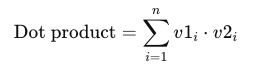

```python
import numpy as np
dot_product = np.dot(vector1, vector2)
```
-------------------

#### Cosine Similarity
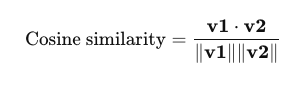

```python
import numpy as np
dot_product = np.dot(vector1, vector2)
mag1 = np.linalg.norm(vector1)
mag2 = np.linalg.norm(vector2)
similarity_score = dot_product / (mag1 * mag2)
```
-------------------

### 2. Euclidean Distance
- Also called L2 distance
- Do not use Euclidean distance for normalized vectors.
 
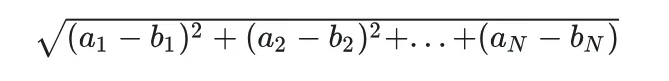

```python
import numpy as np
np.linalg.norm(vector1 - vector2)
```



## [Embedding Model Architecture](https://blog.gopenai.com/nlp-embeddings-embedding-models-and-comparison-86d28b547d64)

### Word Embeddings
All of these trained neural network word embeddings work very similar to TF-IDF and n-gram, bag of words show up frequency. Without positional encodings and attentions like transformer, they lack of real entity dependencies and context understandings.
| Model | Description |
| --- | --- | 
| word2vec | neural network that capture word representations from local word-word co-occurrence 
| GloVe | global vectors that learn word representations from global word-word co-occurrence 
| FastText | learn word representations from subwords, which makes it more effective at handling rare words and out-of-vocabulary words


### Transformer Papers
| Model | Description | Paper Name | Paper Year
| --- | --- | --- | --- |
| Transformer | First one to introduce positional encoding and attention mechanism | Attention Is All You Need | 2016
| BERT | Introduce bidirectional attention, so the sequence of tokens are both forward and backwards co-related | BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding | 2018
| RoBERTa | More news data used for pretraining | RoBERTa: A Robustly Optimized BERT Pretraining Approach | 2019 |
| XLNet | Adopt permutation method during training, consider all possibility of word order | XLNet: Generalized Autoregressive Pretraining for Language Understanding | 2020
| MiniLM | Microsoft, applied knowledge distillation on BERT transformer| MINILM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers | 2020
| MPNet | Microsoft, masked and permuted language modeling | MPNet: Masked and Permuted Pre-training for Language Understanding | 2020

### [Popular Hugging Face Transformers](https://huggingface.co/models?library=sentence-transformers&sort=downloads)
Hugging face is using pytorch

| Model | Description | Model Size | Tensor Type | Output Vector Size
| --- | --- | --- | --- | --- | 
| all-MiniLM-L12-v2 |   | 33.4M | float32 | 384
| all-MiniLM-L6-v2 |   | 22.7M | float32 | 384
| all-mpnet-base-v2 |   | 109M | float32 | 768

In [1]:
import numpy as np
from sentence_transformers import SentenceTransformer
sentences = [
    "def add(a, b): return a + b", 
    "def min(a, b): return a - b", 
    "The quick brown fox jumps over a lazy dog"]

model_miniLM_L6 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

vs = model_miniLM_L6.encode(sentences)

print(np.dot(vs[0], vs[1]))
print(np.dot(vs[1], vs[2]))
print(np.linalg.norm(vs[0]))

/Users/dz/Library/Python/3.9/lib/python/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/dz/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/dz/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/dz/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads a

0.5379666
0.087309256
1.0


In [2]:
model_miniLM_L12 = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

vs = model_miniLM_L12.encode(sentences)
print(np.dot(vs[0], vs[1]))
print(np.dot(vs[1], vs[2]))

/Users/dz/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.5390557
0.069145255


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 0.0225, -0.0783, -0.0230,  ..., -0.0083,  0.0265, -0.0020],
        [ 0.0417,  0.0011, -0.0155,  ..., -0.0218, -0.0636, -0.0088]])
